In [1]:
import numpy as np

In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


RuntimeError: Visible devices cannot be modified after being initialized

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Linformer Multi-Head Attention
# ---------------------------
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        """
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          proj_dim: The projection dimension to which keys and values will be reduced.
        """
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Standard dense weight matrices for Q, K, and V.

        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)

        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        v = tf.matmul(x, self.wv)


        v = self.split_heads(v, batch_size)


        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)
    
        attn_output = v_proj
        # Concatenate heads.
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output

# ---------------------------
# Linformer Transformer Block
# ---------------------------
class LinformerTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, proj_dim, **kwargs):
        super(LinformerTransformerBlock, self).__init__(**kwargs)
        self.attention = LinformerMultiHeadAttention(d_model, num_heads, proj_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, x):
        attn_output = self.attention(x)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# ---------------------------
# Linformer Transformer Classifier Model
# ---------------------------
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple Linformer transformer blocks.
      - Aggregation over the sequence dimension.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data.
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# 80/20 split for training and validation.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the Linformer transformer classifier.
model = build_linformer_transformer_classifier(150, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 150, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_4   │ (None, 150, 16)        │         2,336 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_4             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757 (10.77 KB)

 Trainable params: 2,757 (10.77 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from sklearn.model_selection import train_test_split


In [35]:
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_150const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_150const_ptetaphi.npy")

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)


In [36]:
x_train.shape

(496000, 150, 3)

In [37]:
#model.load_weights('1layerLinformerCompressOne32partCompress1.weights.h5',by_name = True )
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 150, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_4   │ (None, 150, 16)        │         2,336 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_4             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757 (10.77 KB)

 Trainable params: 2,757 (10.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=250, 
    batch_size=1024)

Epoch 1/250


2025-04-04 13:28:23.581027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.3766 - loss: 1.3991 - val_accuracy: 0.6473 - val_loss: 0.9201
Epoch 2/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.6609 - loss: 0.8943 - val_accuracy: 0.6885 - val_loss: 0.8329
Epoch 3/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.6972 - loss: 0.8161 - val_accuracy: 0.7117 - val_loss: 0.7818
Epoch 4/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7176 - loss: 0.7734 - val_accuracy: 0.7231 - val_loss: 0.7599
Epoch 5/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7297 - loss: 0.7465 - val_accuracy: 0.7389 - val_loss: 0.7292
Epoch 6/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7406 - loss: 0.7236 - val_accuracy: 0.7328 - val_loss: 0.7370
Epoch 7/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7458 - loss: 0.7111 - val_accuracy: 0.7483 - val_loss: 0.7071
Epoch 8/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 93s 192ms/step - accuracy: 0.7519 - loss: 0.6983 - val

In [ ]:
model.save_weights('1layerLinformerCompressOne150partCompress1.weights.h5')

In [21]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2025-04-03 14:21:52.581955: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-04-03 14:21:52.582024: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-03 14:21:52.582168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 14:21:52.582181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference: 302446

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. 

In [30]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_150const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_150const_ptetaphi.npy")

In [31]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [32]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.79225

In [46]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_8   │ (None, 32, 16)         │         2,160 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_8             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,745 (30.26 KB)

 Trainable params: 2,581 (10.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,164 (20.18 KB)

In [25]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

1/FPR at TPR=80% for each class:
g: 1/FPR = 11.95622876231066
q: 1/FPR = 8.70221779217543
W: 1/FPR = 35.0362563237774
Z: 1/FPR = 40.46405610753945
t: 1/FPR = 26.658740359897173
Average 1/FPR across classes: 24.56349986914002

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8929
q: accuracy = 0.8686
W: accuracy = 0.9370
Z: accuracy = 0.9400
t: accuracy = 0.9296
Average accuracy across classes: 0.9136


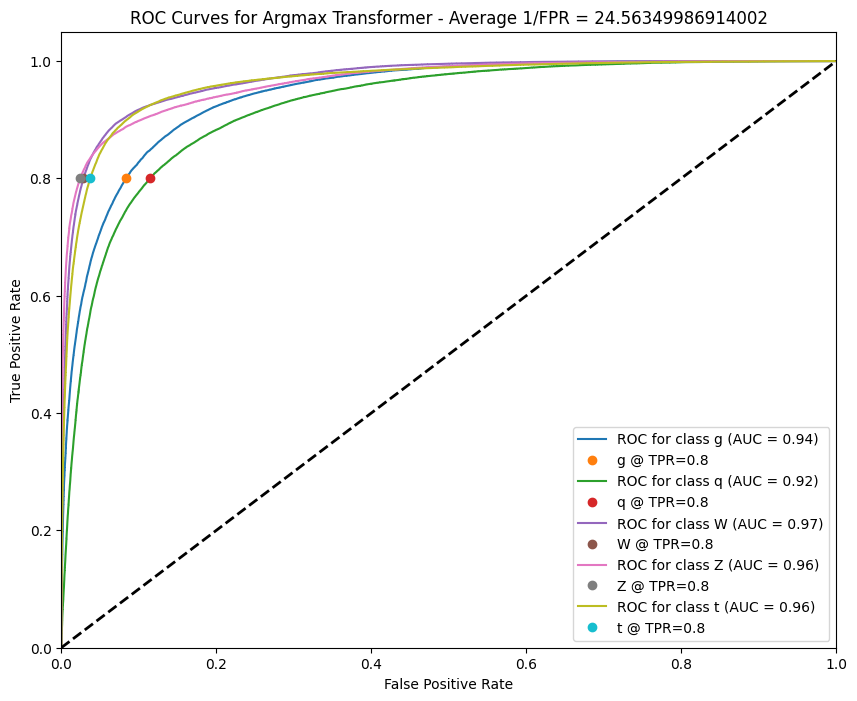

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()



In [52]:
# Build the model with proj_dim = 1.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

# Compile the model (as before).
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load the saved weights.
model.load_weights('1layerLinformerCompress1.weights.h5')

# Optionally, view the model summary.
model.summary()


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_6   │ (None, 16, 16)         │         1,904 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_6             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)